# Exercise 5: Lasso Regression on the Franke function  with resampling (Score 10 points))


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from common import *
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj1_report/code


# 1.5
Start off by defining the data

In [2]:
SEED = 6853
np.random.seed(SEED)
maxdegree = 12
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
t = FrankeFunction(x, y) + noise_factor(n, factor=0.2)
min_lambda = -7
max_lambda = 2
nlambdas = 100
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)

We want to essentially repeat the previous two exercises, as such, this exercise will follow in the footsteps of exercise 4. The difference is that the sci-kit learn implementation of Lasso regression is used. 

# Create a searchlandscape

In [3]:
test_mse = np.zeros((maxdegree, nlambdas))
train_mse = np.zeros_like(test_mse)
model_list = np.empty_like(test_mse, dtype=object)
optimal_deg = 0
optimal_lmb = 0
lambda_degree = 0
best_mse = np.inf

for deg in range(1, maxdegree+1):
    for lmb in range(len(lambdas)):

        X = create_X(x,y,n=deg)

        X_train, X_test, z_train, z_test = prepare_data(X, t.ravel(), SEED, scale_X=True, skip_intercept=True)

        model = lm.Lasso(lambdas[lmb], fit_intercept=False, random_state=SEED)
        model.fit(X_train, z_train)
        z_hat_train = model.predict(X_train)
        z_hat_test = model.predict(X_test)

        test_mse[deg-1,lmb] = MSE(z_test, z_hat_test)
        train_mse[deg-1, lmb] = MSE(z_train, z_hat_train)
        model_list[deg-1,lmb] = model
        
        if test_mse[deg-1,lmb] < best_mse:
            best_mse = test_mse[deg-1, lmb]
            optimal_deg = deg
            optimal_lmb = lambdas[lmb]
            lambda_degree = lmb

print(best_mse)
print(optimal_lmb)
print(optimal_deg)
print(train_mse[deg-1, lmb])
optimal_model = model_list[deg-1, lambda_degree]

0.22346810973800152
0.0003511191734215131
4
0.2904744002358078


In [4]:
import matplotlib.ticker as mticker
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text("Plot of the Search Landscape")
ax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")
#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))
ax.set_xticklabels(f"{deg-2}" for deg in range(1, maxdegree+2,2))

degs, lambs = np.meshgrid(range(maxdegree), range(nlambdas))
print(degs.shape)
print(lambs.shape)
print(test_mse.shape)
ax.scatter(optimal_deg - 1, lambda_degree, best_mse, c='r', marker='o', s=100)

surf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)
ax.view_init(elev=14., azim=-58.)
plt.savefig(f"{REPORT_FIGURES}{EX5}search_landscape_lasso.pdf")
plt.show()

Using matplotlib backend: TkAgg
(100, 12)
(100, 12)
(12, 100)


/tmp/ipykernel_249364/216342859.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f"{deg-2}" for deg in range(1, maxdegree+2,2))


# Bootstrap with Lasso

In [5]:
%matplotlib inline
np.random.seed(SEED)
maxdegree = 18
n_points = [20, 40]
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + noise_factor(n, factor=0.2)

min_lambda = -7
max_lambda = 2
nlambdas=100
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)
#lambdas = [np.log10(min_lambda), optimal_lmb, np.log10(max_lambda)]

Looping trhough polynomials up to 18 with 10: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Elapsed time 5922.8611ms in function bootstrap


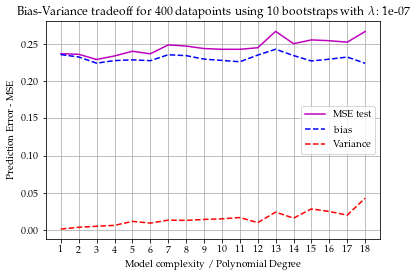

Looping trhough polynomials up to 18 with 10: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]


Elapsed time 4245.8451ms in function bootstrap


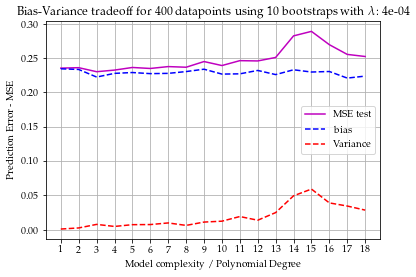

Looping trhough polynomials up to 18 with 10: 100%|██████████| 18/18 [00:00<00:00, 38.63it/s]


Elapsed time 468.4522ms in function bootstrap


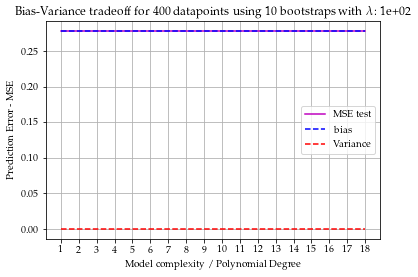

Looping trhough polynomials up to 18 with 20: 100%|██████████| 18/18 [00:12<00:00,  1.45it/s]


Elapsed time 12378.4802ms in function bootstrap


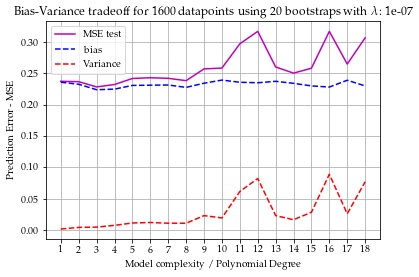

Looping trhough polynomials up to 18 with 20: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


Elapsed time 9746.9282ms in function bootstrap


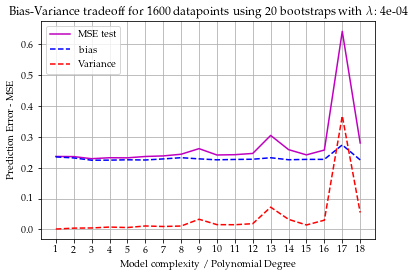

Looping trhough polynomials up to 18 with 20: 100%|██████████| 18/18 [00:01<00:00,  9.12it/s]


Elapsed time 1975.8632ms in function bootstrap


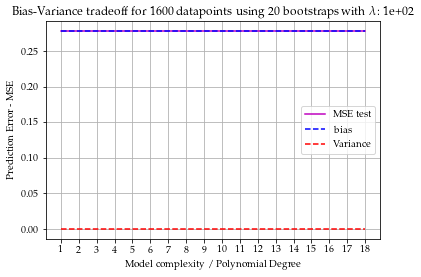

In [6]:
for n in n_points:
    for i in [0, lambda_degree, len(lambdas)-1]:
        n_bootstraps = int(0.5*n)
        lmb = lambdas[i]
        polydegree = np.arange(1, maxdegree+1)
        MSE_test, MSE_train, bias, variance = bootstrap(x, y, z, maxdegree, n_bootstraps, lm.Lasso(lmb, fit_intercept=False, random_state=SEED), SEED, is_scikit=True)

        plt.plot(polydegree, MSE_test,"m", label='MSE test')
        #plt.plot(polydegree, MSE_train,"c", label='MSE train')
        plt.plot(polydegree, bias,"b--", label='bias')
        plt.plot(polydegree, variance,"r--", label='Variance')
        #plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

        plt.title(fr"Bias-Variance tradeoff for {n*n} datapoints using {n_bootstraps} bootstraps with $\lambda$: {lmb:.0e}")
        plt.xlabel("Model complexity / Polynomial Degree")
        plt.ylabel("Prediction Error - MSE")
        plt.xticks(polydegree)
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{REPORT_FIGURES}{EX5}lasso_complexity_using_bootstrap_function_lmb{n}{i}.pdf")
        plt.show()

# Cross Validation

Looping trhough polynomials up to 12 with 10: 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


Elapsed time 1793.2537ms in function bootstrap


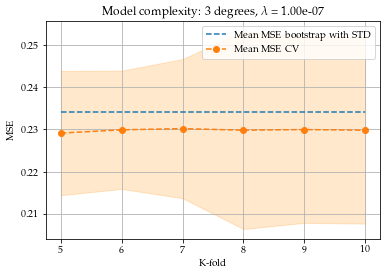

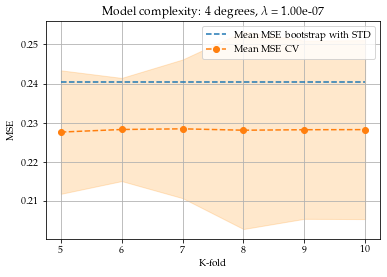

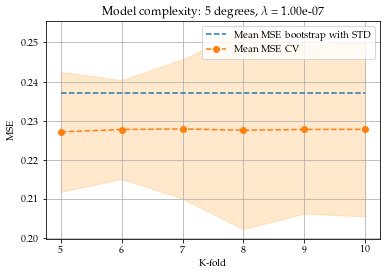

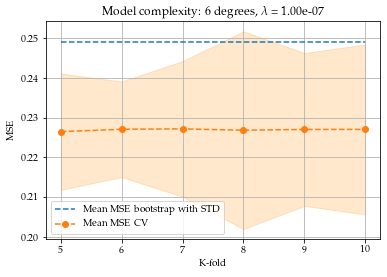

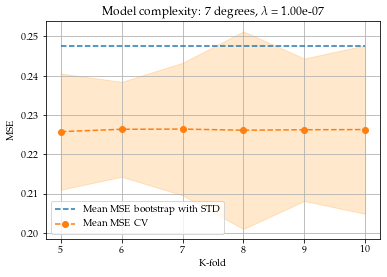

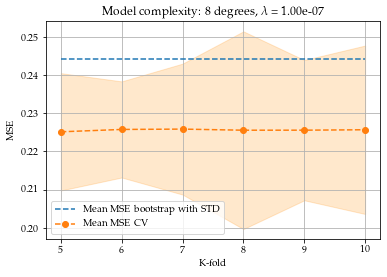

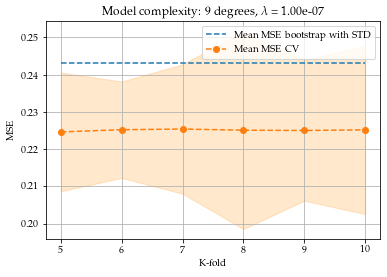

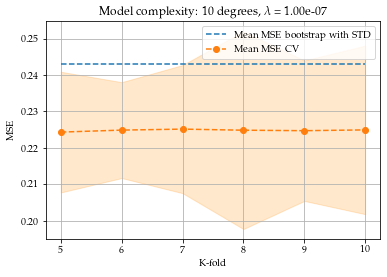

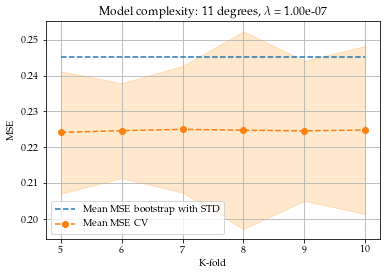

Looping trhough polynomials up to 12 with 10: 100%|██████████| 12/12 [00:01<00:00,  6.31it/s]


Elapsed time 1904.3379ms in function bootstrap


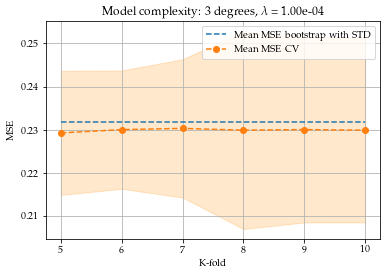

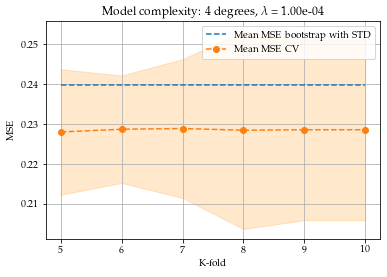

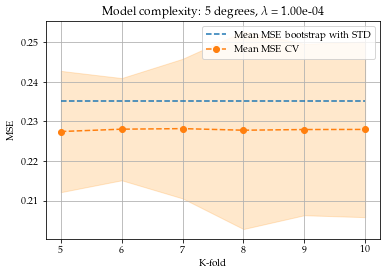

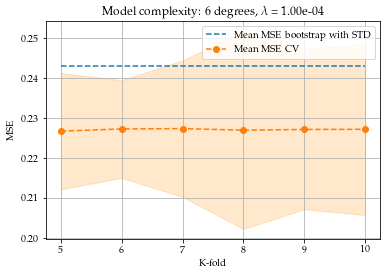

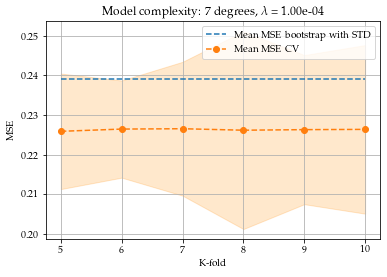

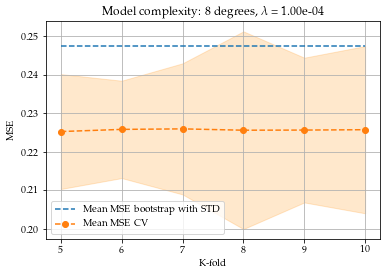

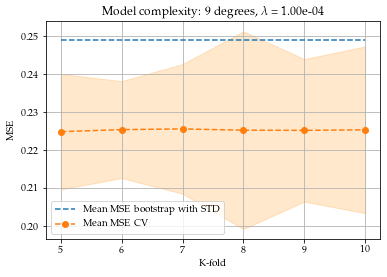

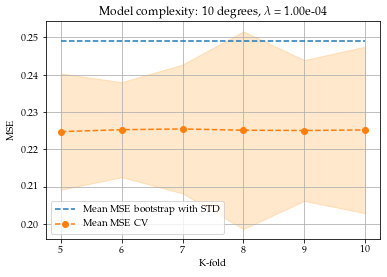

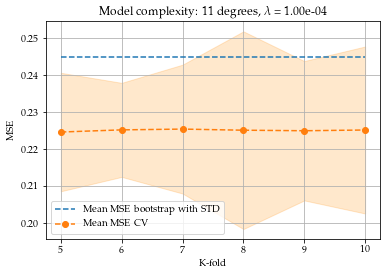

Looping trhough polynomials up to 12 with 10: 100%|██████████| 12/12 [00:00<00:00, 14.66it/s]


Elapsed time 822.6018ms in function bootstrap


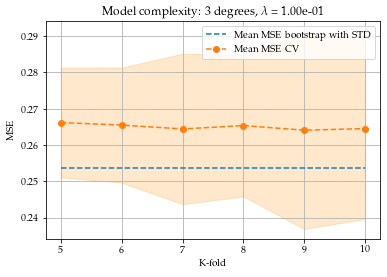

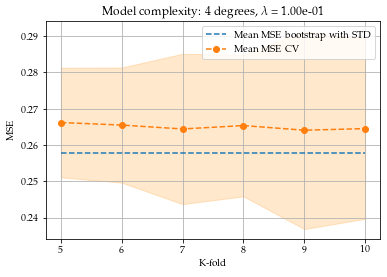

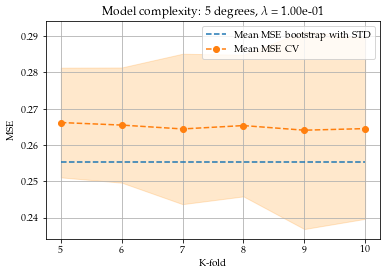

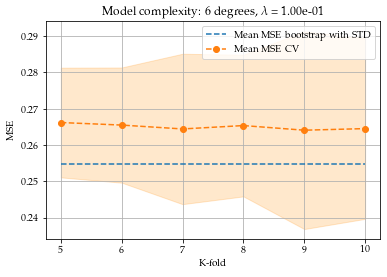

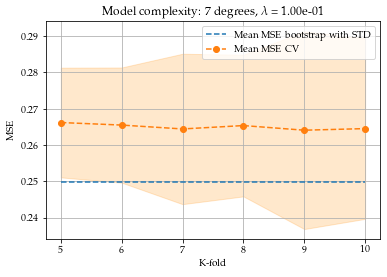

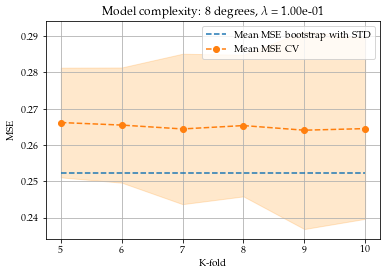

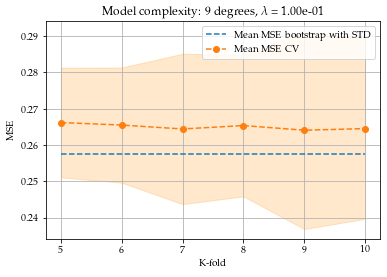

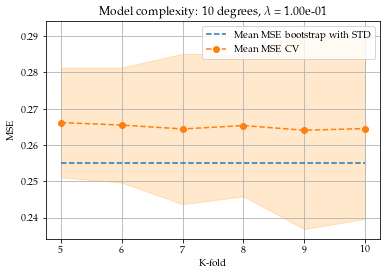

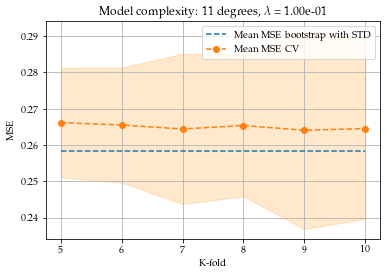

Looping trhough polynomials up to 12 with 10: 100%|██████████| 12/12 [00:00<00:00, 23.38it/s]


Elapsed time 516.5434ms in function bootstrap


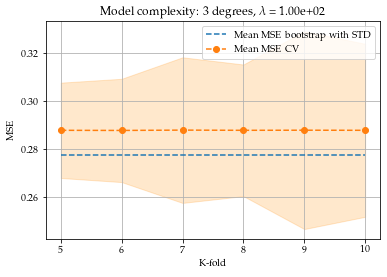

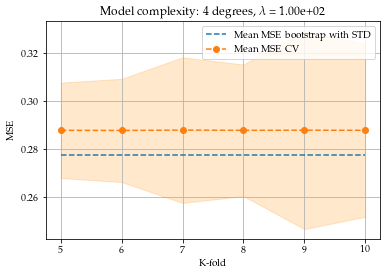

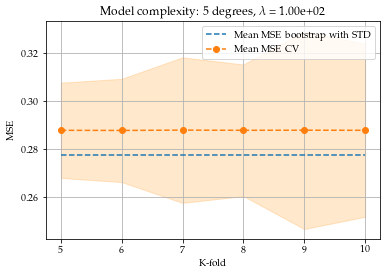

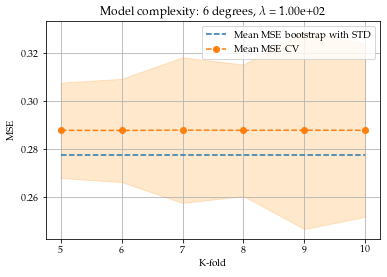

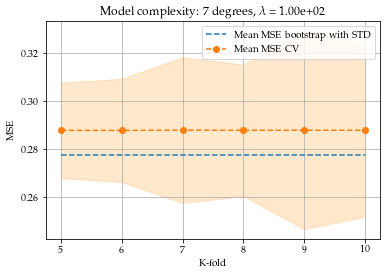

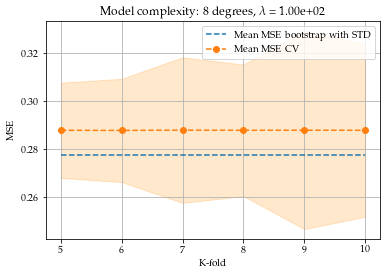

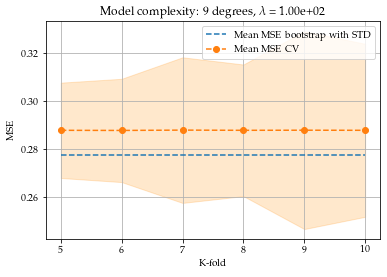

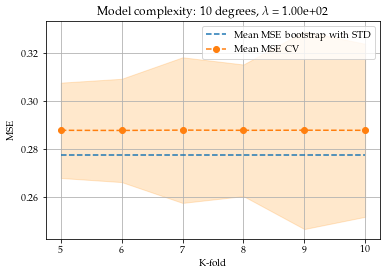

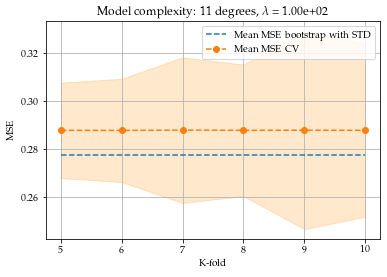

In [7]:
np.random.seed(SEED)
maxdegree = 12
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + noise_factor(n, factor=0.2)

min_lambda = -7
max_lambda = 2
nlambdas = 3
lambdas = np.logspace(min_lambda,max_lambda, nlambdas+1)

for i in range(nlambdas+1):
    lmb = lambdas[i]

    boot_strp_MSE_test, _, _, boot_strp_variance = bootstrap(x, y, z, maxdegree, int(0.5*n), lm.Lasso(lmb, fit_intercept=False, random_state=SEED), SEED, is_scikit=True)
    boot_strp_std = np.sqrt(boot_strp_variance)

    for degree in range(3,maxdegree):
        X = create_X(x,y,degree)
        X = remove_intercept(X)
        
        mean_folds_error = np.zeros(6)
        mse_std_arr = np.zeros(6)
        for folds in range(5,11):
            
            implemented_scores = cross_val(k = folds, model = "Lasso", X = X, z = z, degree=degree,lmb=lmb, shuffle=True, random_state = SEED, scale_t=False)
            mean_folds_error[folds-5] = np.mean(implemented_scores)
            mse_std_arr[folds-5] = np.std(implemented_scores)

        plt.plot(np.arange(5,11), np.ones(6)*boot_strp_MSE_test[degree],"--", label ="Mean MSE bootstrap with STD")
        #plt.fill_between(np.arange(5,11), np.ones(6)*boot_strp_MSE_test[degree]-boot_strp_std[degree],
                        #np.ones(6)*boot_strp_MSE_test[degree]+boot_strp_std[degree], alpha = 0.2 )
        plt.plot(np.arange(5,11), mean_folds_error, "o--",  label = "Mean MSE CV")
        plt.fill_between(np.arange(5,11), mean_folds_error-mse_std_arr, mean_folds_error+mse_std_arr,  alpha = 0.2, color = "darkorange")
        plt.title(fr"Model complexity: {degree} degrees, $\lambda$ = {lmb:.2e}")
        plt.xlabel("K-fold")
        plt.ylabel("MSE")
        #plt.ylim(0,2)
        plt.xticks(np.arange(5,11))
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{REPORT_FIGURES}{EX5}lasso_mse_cv_boot{i}{degree}.pdf")

        plt.show()